# Анализ вариабельности сердечного ритма

In [1]:
from typing import List, Callable, Sequence

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import scipy.io
from scipy.integrate import simps
import pandas as pd
from scipy import signal
from scipy.integrate import trapz
from scipy import stats
from scipy.interpolate import CubicSpline
import random
import datetime

%matplotlib inline

#### Загрузка данных

In [2]:
def load_ECG(pathname: str) -> np.ndarray:
    '''Загрузка .mat-файла и формирование массива сигнала ЭКГ
    в нужном масштабе.
    
    Parameters
    ----------
    pathname : str
        Путь к файлу с именем.
        
    Returns
    -------
    ECG : np.ndarray
        Отмасштабированный сигнал ЭКГ.
    '''
    ECG = scipy.io.loadmat(pathname)
    gain = 600
    try:
        ECG = ECG['data'][:,0]
    except KeyError:
        ECG = ECG['val'][0,:]/gain
    return ECG

In [2]:
# Частота дискретизации
Fd = 250

### Выделение R пика

#### Фильтрация

In [4]:
def butter_filter_coeff(cutoff, fs, order, btype):
    '''
    Butterworth filter coefficients
    
    Parameters:
    cutoff - filter cutoff frequency
    fs - sampling frequency
    order - filter order
    btype - filter type (low or high)
    
    return: b, a - filter coefficients
    '''
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

def butter_filtration(data, cutoff, fs, order, btype):
    '''
    Filtration data with a butterworth filter
    
    Parameters:
    data - signal
    cutoff - filter cutoff frequency
    fs - sampling frequency
    order - filter order
    btype - filter type (low or high)
    
    return: y - filtered data
    '''
    b, a = butter_filter_coeff(cutoff, fs, order, btype)
    y = signal.lfilter(b, a, data)
    return y

In [5]:
def reverse_filt(data, cutoff, fs, order, btype):
    '''
    Reverse filtration data with a butterworth filter
    
    Parameters:
    data - signal
    cutoff - filter cutoff frequency
    fs - sampling frequency
    order - filter order
    btype - filter type (low or high)
    
    return: y - reverse filtered data
    '''
    reverse_data = data[::-1]
    b, a = butter_filter_coeff(cutoff, fs, order, btype)
    y = signal.lfilter(b, a, reverse_data)[::-1]
    
    return y

In [6]:
def filter_response(cutoff, fs, order, btype):
    '''
    Butterworth filter frequency response
    
    Parameters:
    b, a - filter coefficients
    cutoff - filter cutoff frequency
    fs - sampling frequency
    order - filter order
    
    return: frequency response plot
    '''
    b, a = butter_filter_coeff(cutoff, fs, order, btype)
    w, h = signal.freqz(b, a, worN=8000)
    plt.figure(figsize=(11,3))
    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title(str(btype) + 'pass filter frequency response')
    plt.xlabel('Frequency $Hz$')
    plt.grid()

In [7]:
def diff(data):
    '''
    Differentiation
    
    Parameters:
    data - signal
    
    return: diff - list of differentiated data
    '''
    diff = []
    
    for i in range(2, len(data)):
            diff.append(data[i] - data[i-2])
            
    diff.append(0.0) #Добавим два нуля в конец 
    diff.append(0.0)
    
    return np.array(diff)

#### Моделирование фильтров:
#### Для выделения R-пиков два фильтра Баттерворта 4 порядка: ФНЧ и ФВЧ с частотами среза 15 Гц и 5 Гц соответственно
#### Для фильтрации два фильтра Баттерворта 2 порядка: ФНЧ и ФВЧ с частотами среза 25 Гц и 0.5 Гц соответственно

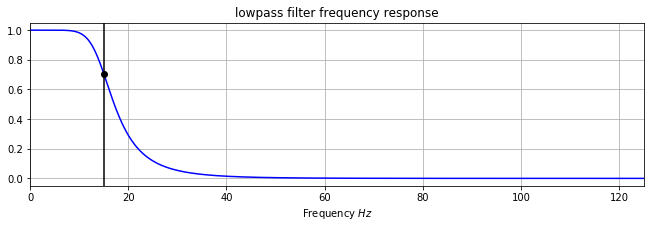

In [8]:
filter_response(cutoff = 15, fs = Fd, order = 4, btype = 'low')

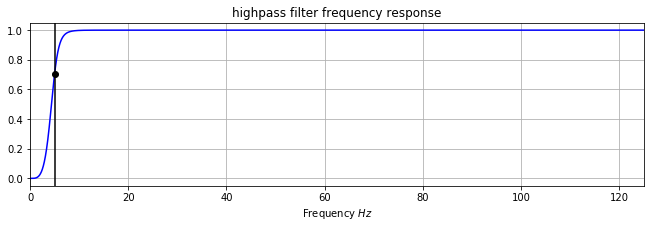

In [9]:
filter_response(cutoff = 5, fs = Fd, order = 4, btype = 'high')

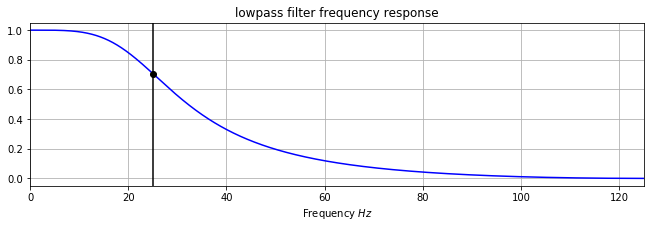

In [10]:
filter_response(cutoff = 25, fs = Fd, order = 2, btype = 'low')

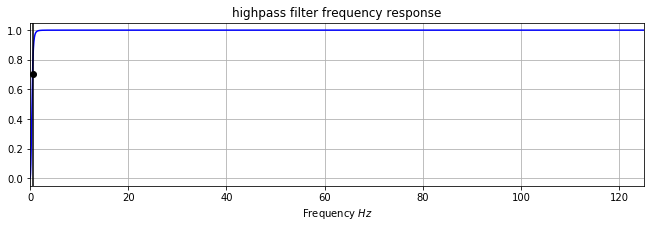

In [11]:
filter_response(cutoff = 0.5, fs = Fd, order = 2, btype = 'high')

#### Удаление тренда из сигнала

In [12]:
def detrend(data):
    data = data.astype('float32')
    data -= np.mean(data)
    return data

#### Базовая фильтрация

In [13]:
def basefilt(data, fs, cutoff = [25, 0.5], order = 2):
    
    filtred_data = detrend(data)
    filtred_data = butter_filtration(filtred_data, cutoff = max(cutoff), fs = fs, order = order, btype = 'low')
    filtred_data = reverse_filt(filtred_data, cutoff = max(cutoff), fs = fs, order = order, btype = 'low')
    filtred_data = butter_filtration(filtred_data, cutoff = min(cutoff), fs = fs, order = order, btype = 'high')
    filtred_data = reverse_filt(filtred_data, cutoff = min(cutoff), fs = fs, order = order, btype = 'high')
    
    return filtred_data

#### Фильтрация для выделения RR в две стороны (для ликвидации сдвига по времени)

In [14]:
def filtRR(data, fs, cutoff = [15, 5], order = 4):
    
    filtred_data = detrend(data)
    filtred_data = butter_filtration(filtred_data, cutoff = max(cutoff), fs = fs, order = order, btype = 'low')
    filtred_data = reverse_filt(filtred_data, cutoff = max(cutoff), fs = fs, order = order, btype = 'low')
    filtred_data = butter_filtration(filtred_data, cutoff = min(cutoff), fs = fs, order = order, btype = 'high')
    filtred_data = reverse_filt(filtred_data, cutoff = min(cutoff), fs = fs, order = order, btype = 'high')
    
    return filtred_data

#### График

In [15]:
def plot(data_x, data_y, title, xlabel, ylabel):
    
    plt.figure(figsize = (10,5))
    plt.plot(data_x, data_y)
    plt.xlim([data_x[0], data_x[-1]])
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.tick_params(axis='both', labelsize = 12)
    plt.grid()

#### Сигнал ЭКГ до и после фильтрации

In [16]:
def BeforeAfter(data1, data2, fs):
    
    t = [i/fs for i in range(fs*4)]
    
    plt.figure(figsize = (10,5))
    plt.plot(t, data1[:fs*4])
    plt.xlim([data1[0], 4])
    plt.xlabel('$t, с$', fontsize=14)
    plt.ylabel('$Напряжение, мВ$', fontsize=14)
    plt.title('Исходный сигнал', fontsize=16)
    plt.tick_params(axis='both', labelsize = 12)
    plt.axvline(1, color = 'k', linewidth = 2, linestyle = ':')
    plt.axvline(2, color = 'k', linewidth = 2, linestyle = ':')
    plt.axvline(3, color = 'k', linewidth = 2, linestyle = ':')
    plt.axvline(4, color = 'k', linewidth = 2, linestyle = ':')
    plt.grid()
    
    plt.figure(figsize = (10,5))
    plt.plot(t, data2[:fs*4])
    plt.xlim([data2[0], 4])
    plt.xlabel('$t, с$', fontsize=14)
    plt.ylabel('$Напряжение, мВ$', fontsize=14)
    plt.title('Сигнал после преобразования', fontsize=16)
    plt.tick_params(axis='both', labelsize = 12)
    plt.axvline(1, color = 'k', linewidth = 2, linestyle = ':')
    plt.axvline(2, color = 'k', linewidth = 2, linestyle = ':')
    plt.axvline(3, color = 'k', linewidth = 2, linestyle = ':')
    plt.axvline(4, color = 'k', linewidth = 2, linestyle = ':')
    plt.grid()

### Выделения R-пика с помощью алгоритма Пана-Томпкинса с простым пороговым методом
###### Этапы:
1. Фильтрация
2. Дифференцирование
3. Квадратирование
4. Скользящее среднее
5. Пороговый метод

#### Простое скользящее среднее

In [17]:
def simple_mov_average(data, fs):
    
    order = int(fs*0.15) # Количество значений для усреднения выбирается таким образом, чтобы усреднить на окне 150 мс
    SMA = []
    for i in range(order - 1): # Нули в начало для компенсации
        SMA.append(0.)
    for i in range(len(data) - order + 1):
        SMA.append(sum(data[i: i + order]) / order)
        
    return np.array(SMA)

In [18]:
def PanTomAlg(data, fs):
    
    filtered_data = filtRR(data, fs) # Фильтрация
    
    diff_I = diff(filtered_data) * 150 # Дифференцирование и компенсация падения амплитуды после дифференцирования
    
    square = diff_I**2 # Квадратирование
    
    mov_avg = simple_mov_average(square, fs) # Скользящее среднее
    
    coord = [] # Массив координат R-пиков
    refractory_period = 0.2 # Интервал, в течение которого возбудимая ткань не способна генерировать повторный потенциал
    count = 0
    lvl = 0.2 # Порог
    
    for i in range(len(mov_avg)):
        if mov_avg[i] > lvl:
            if count == 0:
                count2 = 0
                y_max = max(mov_avg[i:i + int(fs * refractory_period)])
                for j in mov_avg[i:i + int(fs * refractory_period)]:
                    if j == y_max:
                        coord.append(i + count2)
                        break
                    count2 += 1
            count += 1
        if count == int(fs * refractory_period):
            count = 0
    
    return coord

#### Создание массива RR-интервалов

In [19]:
def RR_int(R_peaks, fs):
    rr_int = []
    for i in range(len(R_peaks) - 1):
        rr_int.append((R_peaks[i+1] - R_peaks[i]) / fs)
    return rr_int

#### Массив NN интервалов, где вместо выбросов медиана

In [20]:
def create_NN(RR):
    NN = []
    for i in range(len(RR)):
        if RR[i] < 0.4 or RR[i] > 1.4:
            NN.append(np.median(RR))
        else:
            NN.append(RR[i])
    return np.array(NN)

### Ритмограмма

In [21]:
def rythm(NN):
    maxRR = max(NN) # Максимальная длина NN-интервала (с)
    maxRRp = maxRR*1.2

    plt.figure(figsize=(10,5))
    plt.xlim(0, len(NN))
    plt.ylim(0, maxRRp)
    plt.xlabel('n', fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    plt.ylabel('RR, c', fontsize=14)
    plt.title('Ритмограмма', fontsize=16)
    for i in range(1, len(NN) + 1):
        x = []
        R = []
        x.append(i)
        x.append(i)
        R.append(0)
        R.append(NN[i-1])
        plt.plot(x,R)
    
    return

## Расчет показателей ВСР

#### ЧСС (уд/мин)

In [22]:
def HR(NN):
    return int(round(len(NN)/sum(NN)*60))

#### Среднее значение (мс)

In [23]:
def mRR(NN):
    return round(sum(NN)/len(NN)*1000,2)

#### СКО (мс)

In [24]:
def sdRR(NN):
    return round(np.std(NN)*1000,2)

#### Коэффициент вариации (%)

In [25]:
def CV(NN):
    return round(sdRR(NN)/mRR(NN)*100,2)

#### Среднеквадратичная разностная характеристика (мс)

In [26]:
def RMSSD(NN):
    if type(NN) != type(np.array([])): # Преобразуем тип входного массива при необходимости
        NN = np.array(NN)

    return round(np.sqrt(np.mean(((NN[1:] - NN[:-1])*1000)**2)),2)

#### Процент разностных интервалов (X_i+1 - X_i) > 50 мс (%)

In [27]:
def PNN50(NN):
    if type(NN) != type(np.array([])): # Преобразуем тип входного массива при необходимости
        NN = np.array(NN)
    
    return round(sum(abs((NN[1:] - NN[:-1])*1000) > 50)/len(NN)*100,2)

#### Коэффициент асимметрии

In [28]:
def As(NN):
    return round(stats.skew(NN),4)

### Геометрический анализ

#### Гистограмма и амплитуда моды (%) (Норма 30-50)

In [29]:
def hist_AMo(NN, hist = False):
    len_step = 0.05 # Шаг гистограммы (50 мс по умолчанию)
    
    if type(NN) != type(np.array([])): # Преобразуем тип входного массива при необходимости
        NN = np.array(NN)
        
    maxRR = max(NN) # Максимальная длина NN-интервала (с)
    minRR = min(NN) # Минимальная длина NN-интервала (с)
    X = np.array([i for i in range(int(0.3*1000), int(1.7*1000), 50)]) / 1000 # Переменная по оси абсцисс (NN, с)

    X_ms = X*1000 # Переменная по оси абсцисс (NN, мс)
    NN_ms = NN*1000 # NN-интервалы в мс

    histogr = []

    for i in range(len(X)): # Расчет гистограммы
        histogr.append(len(NN[np.where((NN_ms >= X_ms[i]) & (NN_ms < X_ms[i] + len_step*1000))]))

    SH = sum(histogr) # Сумма гистограммы (число NN-интервалов)
    histogr = np.array(histogr) / SH * 100 # Получение гистограммы в % 
    max_hist = max(histogr)
    
    #=================================================================
    AMo = round(max_hist, 1) # Амплитуда моды (%)
    #=================================================================
    
    if hist == True:
        plt.figure(figsize=(10,5))
        plt.bar(X, histogr, len_step, align = 'edge', edgecolor = 'k') # Построение гистограммы
        plt.axvline(0.7, color = 'k', linewidth = 2)
        plt.axvline(1.1, color = 'k', linewidth = 2)
        plt.minorticks_on()
        plt.text(0.4, 9/8*int(max_hist), '$Тахикардия$', fontsize=15)
        plt.text(0.76, 9/8*int(max_hist), '$Нормокардия$', fontsize=15)
        plt.text(1.15, 9/8*int(max_hist), '$Брадикардия$', fontsize=15)
        plt.xlim(0.3, 1.7)
        plt.ylim(0, 5/4*int(max_hist))
        plt.xlabel('$RR, c$', fontsize=14)
        plt.ylabel('$Частота,$ %', fontsize=14)
        plt.title('Гистограмма', fontsize=16)
        plt.tick_params(axis='both', labelsize=12)
        plt.grid(which = 'major', 
                color = 'k', 
                linewidth = 0.5)
        plt.grid(which = 'minor', 
                color = 'k', 
                linestyle = ':')
        return
    return AMo

#### Вариационный размах (мс) (Норма 150-300)

In [30]:
def MxDMn(NN):
    return round((max(NN) - min(NN))*1000)

#### Мода (мс) (Норма 700-900)

In [31]:
def Mo(NN):
    return round(stats.mode(NN).mode[0]*1000)

#### Стресс-индекс (Норма 50-150)

In [32]:
def SI(NN):
    return round(hist_AMo(NN)/(2*Mo(NN)*MxDMn(NN)/1000000))

#### Индекс вегетативного равновесия (Норма 100-300)

In [33]:
def IVR(NN):
    return round(hist_AMo(NN)*1000/MxDMn(NN),2)

#### Вегетативный показатель ритма (Норма 7.1-9.3)

In [34]:
def VPR(NN):
    return round(1/(Mo(NN)*MxDMn(NN)/1000000),2)

#### Показатель адекватности процессов регуляции (Норма 35-70)

In [35]:
def PAPR(NN):
    return round(hist_AMo(NN)*1000/Mo(NN),2)

### Скатерограмма

In [36]:
def scplot(NN):
    plt.figure(figsize=(10,6))
    plt.scatter(NN[:-2],NN[1:-1], edgecolors='k')
    ax = plt.gca()
    ellipse = Ellipse(xy=(0.9, 0.9), width = np.sqrt(2)*0.2, height = np.sqrt(2)*0.4, 
                            edgecolor = 'g', fc='None', lw = 2, angle = -45)
    plt.plot([0.3, 1.7], [0.3, 1.7], c = 'k', lw = 1, alpha = 0.7)
    ax.add_patch(ellipse)
    plt.minorticks_on()
    plt.xlim(0.3, 1.7)
    plt.ylim(0.3, 1.7)
    plt.xlabel('$RR_i$, c', fontsize=14)
    plt.ylabel('$RR_{i+1}$, c', fontsize=14)
    plt.title('Скатерограмма', fontsize=16)
    plt.tick_params(axis='both', labelsize=12)
    plt.grid(which = 'major', 
            color = 'k', 
            linewidth = 0.5)
    plt.grid(which = 'minor', 
            color = 'k', 
            linestyle = ':')

### Спектральный анализ

#### Интерполяция ритмограммы кубическими сплайнами и дискретизация с частотой 4 Гц

In [37]:
def interpolate(NN):
    t = 0
    x = [] 
    for i in range(len(NN)): # Расчет переменной времени
        t += NN[i]
        x.append(t)
    
    x = np.array(x)
    y = NN
    Fd = 4 # Частота дискретизации - стандартное значение 4 Гц
    T = 1/Fd # Период дискретизации
    cs = CubicSpline(x, y) # Рассчет сплайнов
    xs = np.arange(1, x[-1], T)
    
    return cs(xs)

#### Расчет СПМ

In [38]:
def PSD(interpolated_NN, plot = False):
    nfft = 2048 # Число точек для алгоритма БПФ
    interpolated_NN -= np.mean(interpolated_NN) # Удаление постоянной сосставляющей
    fs = 4.0
    df = fs/nfft # Шаг по частоте
    f, Pxx_den = signal.periodogram(interpolated_NN, fs, nfft = nfft) # Расчет СПМ в (с^2/Гц)
    Pxx_den = Pxx_den*1000000 # СПМ (мс^2/Гц)
    
    if plot == True:
        plt.figure(figsize=(10,5))
        plt.plot(f, Pxx_den, c = 'k')
        plt.xlim([0, 0.4])
        plt.ylim([0, max(Pxx_den)*1.2])
        plt.xlabel('$Частота, Гц$', fontsize=14)
        plt.ylabel('$мс^2/Гц$', fontsize=14)
        plt.title('Спектральная плотность мощности', fontsize=16)
        plt.tick_params(axis='both', labelsize = 12)
        plt.axvline(0.04, color = 'k', linewidth = 1)
        plt.axvline(0.15, color = 'k', linewidth = 1)
        plt.fill_between(f[f<0.04], y1=Pxx_den[f<0.04], y2=0, alpha=0.75, color='mediumseagreen', linewidth=1)
        plt.fill_between(f[f>=0.04], y1=Pxx_den[f>=0.04], y2=0, alpha=0.5, color='orange', linewidth=1)
        plt.fill_between(f[f>0.15], y1=Pxx_den[f>0.15], y2=0, alpha=0.55, color='red', linewidth=1)
        plt.grid()

        plt.text(0.0125, max(Pxx_den)*1.1, '$VLF$', fontsize=15)
        plt.text(0.085, max(Pxx_den)*1.1, '$LF$', fontsize=15)
        plt.text(0.27, max(Pxx_den)*1.1, '$HF$', fontsize=15)
        plt.show()
        return
    
    return f, Pxx_den, df

#### Спектральные показатели

In [39]:
def VLF(PowerDen,freq,dfreq): # Мощность волн очень низкой частоты в диапазоне от 0,04 и ниже (Норма 765 ± 410 мс^2)
    return sum(PowerDen[np.where((freq >= 0) & (freq < 0.04))])*dfreq

In [40]:
def LF(PowerDen,freq,dfreq): # Мощность волн низкой частоты в диапазоне от 0,15 до 0,04 Гц (Норма 1170 ± 416 мс^2)
    return sum(PowerDen[np.where((freq >= 0.04) & (freq < 0.15))])*dfreq

In [41]:
def HF(PowerDen,freq,dfreq): # Мощность волн высокой частоты в диапазоне от 0,4 до 0,15 Гц (Норма 975 ± 203 мс^2)
    return sum(PowerDen[np.where((freq >= 0.15) & (freq <= 0.4))])*dfreq

In [42]:
def TP(PowerDen,freq,dfreq): # Общая мощность спектра (Норма 3446 ± 1018 мс^2)
    return sum(PowerDen[np.where((freq >= 0) & (freq <= 0.4))])*dfreq

In [43]:
def LFHF(PowerDen,freq,dfreq): # Коэффициент вагосимпатического баланса (Норма 0.7 ± 1.5 мс^2)
    return LF(PowerDen,freq,dfreq)/HF(PowerDen,freq,dfreq)

In [44]:
def HFp(PowerDen,freq,dfreq): # Относительное значение мощности волн высокой частоты (Норма 35.79 ± 14.74 %)
    return HF(PowerDen,freq,dfreq)/TP(PowerDen,freq,dfreq)*100

In [45]:
def LFp(PowerDen,freq,dfreq): # Относительное значение мощности волн низкой частоты (Норма 33.68 ± 9.04 %)
    return LF(PowerDen,freq,dfreq)/TP(PowerDen,freq,dfreq)*100

In [46]:
def VLFp(PowerDen,freq,dfreq): # Относительное значение мощности волн очень низкой частоты (Норма 28.65 ± 11.24 %)
    return VLF(PowerDen,freq,dfreq)/TP(PowerDen,freq,dfreq)*100

In [47]:
# Относительное значение мощности волн высокой частоты, выраженное в нормализованных единицах (Норма 49.4 ± 9.4 %)
def relativeHF(PowerDen,freq,dfreq):
    return HF(PowerDen,freq,dfreq)/(TP(PowerDen,freq,dfreq) - VLF(PowerDen,freq,dfreq))*100

In [48]:
# Относительное значение мощности волн низкой частоты, выраженное в нормализованных единицах (Норма 50.6 ± 9.4 %)
def relativeLF(PowerDen,freq,dfreq):
    return LF(PowerDen,freq,dfreq)/(TP(PowerDen,freq,dfreq) - VLF(PowerDen,freq,dfreq))*100

In [49]:
def IC(PowerDen,freq,dfreq): # Индекс централизации (Норма <= 3)
    return (VLF(PowerDen,freq,dfreq) + LF(PowerDen,freq,dfreq))/HF(PowerDen,freq,dfreq)

### Расчет показателя активности регуляторных систем (ПАРС)

#### А. Суммарный эффект регуляции

In [50]:
def SER(NN):
    if mRR(NN)/1000 < 0.66:
        return 2, 'Выраженная тахикардия'
    elif mRR(NN)/1000 >= 0.66 and mRR(NN)/1000 <= 0.8:
        return 1, 'Умеренная тахикардия'
    elif mRR(NN)/1000 > 0.8 and mRR(NN)/1000 <= 1.0:
        return 0, 'Нормокардия'
    elif mRR(NN)/1000 > 1.0 and mRR(NN)/1000 <= 1.2:
        return -1, 'Умеренная брадикардия'
    else:
        return -2, 'Выраженная брадикардия'

#### Б. Функция автоматизма

In [51]:
def AF(NN):
    if sdRR(NN)/1000 <= 0.02 and MxDMn(NN)/1000 <= 0.1*mRR(NN)/1000 and CV(NN) <= 2.0:
        return 2, 'Стабильный ритм'
    elif sdRR(NN)/1000 >= 0.1 and MxDMn(NN)/1000 > 0.3*mRR(NN)/1000 and CV(NN) > 8.0:
        return 1, 'Выраженная синусовая аритмия'
    elif MxDMn(NN)/1000 >= 0.11*mRR(NN)/1000 and MxDMn(NN)/1000 <= 0.3*mRR(NN)/1000:
        return 0, 'Умеренная синусовая аритмия'
    elif MxDMn(NN)/1000 > 0.45*mRR(NN)/1000:
        return -1, 'Умеренное нарушение автоматизма'
    elif sdRR(NN)/1000 > 0.11 and MxDMn(NN)/1000 > 0.6*mRR(NN)/1000 and CV(NN) > 8.0:
        return -2, 'Выраженное нарушение автоматизма'
    else:
        return 0, 'Не удалось определить'

#### В. Вегетативный гомеостаз

In [52]:
def VG(NN):
    if MxDMn(NN)/1000 < 0.06 and hist_AMo(NN) > 80 and SI(NN) > 500:
        return 2, 'Выраженное преобладание симпатической НС'
    elif MxDMn(NN)/1000 < 0.15 and hist_AMo(NN) > 50 and SI(NN) > 200:
        return 1, 'Умеренное преобладание симпатической НС'
    elif MxDMn(NN)/1000>=0.15 and MxDMn(NN)/1000<=0.3 and hist_AMo(NN)<=50 and hist_AMo(NN)>=30 and SI(NN)>=50 and SI(NN)<=200:
        return 0, 'Вегетативный гомеостаз сохранен'
    elif MxDMn(NN)/1000 > 0.3 and hist_AMo(NN) < 30 and SI(NN) < 50:
        return -1, 'Умеренное преобладание парасимпатической НС'
    elif MxDMn(NN)/1000 > 0.5 and hist_AMo(NN) < 15 and SI(NN) < 25:
        return -2, 'Выраженное преобладание парасимпатической НС'
    else:
        return 0, 'Вегетативный гомеостаз сохранен'

#### Г. Устойчивость регуляции

In [53]:
def UR(NN):
    if CV(NN) < 3.00:
        return 2, 'Дисрегуляция'
    elif CV(NN) >= 3.0 and CV(NN) <= 12.0:
        return 0, 'Устойчивая регуляция'
    else:
        return -2, 'Дисрегуляция'

#### Д. Активность подкорковых нервных центров

In [54]:
def APNC(NN, PowerDen, freq, dfreq):
    if VLFp(PowerDen,freq,dfreq) > 70 and LFp(PowerDen,freq,dfreq) > 25 and HFp(PowerDen,freq,dfreq) < 5:
        return 2, 'Выраженное усиление'
    elif VLFp(PowerDen,freq,dfreq) > 60 and HFp(PowerDen,freq,dfreq) < 20:
        return 1, 'Умеренное усиление'
    elif VLFp(PowerDen,freq,dfreq) >= 40 and VLFp(PowerDen,freq,dfreq) <= 60 and HFp(PowerDen,freq,dfreq) >= 20 and HFp(PowerDen,freq,dfreq) <= 30:
        return 0, 'Нормальная активность подкорковых нервных центров'
    elif VLFp(PowerDen,freq,dfreq) < 40 and HFp(PowerDen,freq,dfreq) > 30:
        return -1, 'Умеренное ослабление'
    elif VLFp(PowerDen,freq,dfreq) < 20 and HFp(PowerDen,freq,dfreq) > 40:
        return -2, 'Выраженное ослабление'
    else:
        return 0, 'Нормальная активность подкорковых нервных центров'

#### ПАРС = |А|+|Б|+|В|+|Г|+|Д|

In [55]:
def PARS(NN, PowerDen, freq, dfreq):
    return abs(SER(NN)[0]) + abs(AF(NN)[0]) + abs(VG(NN)[0]) + abs(UR(NN)[0]) + abs(APNC(NN, PowerDen, freq, dfreq)[0])

In [56]:
def start():
    
    FIO = input('ФИО: ')
    gender = input('\nПол: ')
    age = input('\nВозраст: ')
    date = datetime.datetime.now()
    filepath = input('\nПуть к файлу ЭКГ: ')
    Fd = int(input('\nЧастота дискретизации: '))
    print('\nДата и время обследования: ' + str(date))
    
    ecg = load_ECG(filepath) # Загрузка сигнала ЭКГ
    
    ecg_basefilt = basefilt(ecg, Fd) # Предварительная фильтрация
    
    t = [i/Fd for i in range(Fd*2, Fd*5)] # Аргумент времени для графиков
    
    plot(t, ecg_basefilt[Fd*2:Fd*5], title = 'Электрокадиограмма', xlabel = '$t, c$', ylabel = 'Напряжение, мВ') # График сигнала
    
    ecg_filtRR = filtRR(ecg, Fd) # Фильтрация для выделения RR
    
    R_coord = PanTomAlg(ecg, Fd) # Алгоритм Пана-Томпкинсона
    
    rr = RR_int(R_coord, Fd) # Расчет RR-интервалов
    
    nn = create_NN(rr) # Выборка нормальных сокращений
    
    rythm(nn) # Ритмограмма
    
    hist_AMo(nn, hist = True) # Гистограмма
    
    scplot(nn) # Скатерограмма
    
    inter_NN = interpolate(nn) # Интерполяция ритмограммы кубическими сплайнами и дискретизация с частотой 4 Гц
    
    f, Pxx_den, df = PSD(inter_NN) # Расчет спектральной плотности мощности
    
    PSD(inter_NN, plot = True) # График спектральной плотности мощности
    print('\033[1m' + 'ОЦЕНКА СОСТОЯНИЯ РЕГУЛЯТОРНЫХ СИСТЕМ\n' + '\033[0m')
    print('Суммарный эффект регуляции:  \033[1m{}\033[0m - ({})'.format(SER(nn)[1], SER(nn)[0]))
    print('Функция автоматизма:  \033[1m{}\033[0m - ({})'.format(AF(nn)[1], AF(nn)[0]))
    print('Вегетативный гомеостаз:  \033[1m{}\033[0m - ({})'.format(VG(nn)[1], VG(nn)[0]))
    print('Устойчивость регуляции:  \033[1m{}\033[0m - ({})'.format(UR(nn)[1], UR(nn)[0]))
    print('Активность подкорковых нервных центров:  \033[1m{}\033[0m - ({})'.format(APNC(nn, Pxx_den, f, df)[1], APNC(nn, Pxx_den, f, df)[0]))
    
    print('\n\033[1m\nОЦЕНКА ФУНКЦИОНАЛЬНОГО СОСТОЯНИЯ\n\033[0m')
    if PARS(nn, Pxx_den, f, df) <= 2:
        print('\033[91m\033[1mНорма\033[0m')
    elif PARS(nn, Pxx_den, f, df) == 3 or PARS(nn, Pxx_den, f, df) == 4:
        print('\033[91m\033[1mУмеренное функциональное напряжение\033[0m')
    elif PARS(nn, Pxx_den, f, df) == 5 or PARS(nn, Pxx_den, f, df) == 6:
        print('\033[91m\033[1mВыраженное функциональное напряжение\033[0m')
    elif PARS(nn, Pxx_den, f, df) == 7:
        print('\033[91m\033[1mРезко выраженное функциональное напряжение (перенапряжение регуляторных систем)\033[0m')
    elif PARS(nn, Pxx_den, f, df) == 8:
        print('\033[91m\033[1mАстенизация (истощение) регуляторных систем\033[0m')
    else:
        print('\033[91m\033[1mСрыв адаптации\033[0m')
    
    print('Ваш показатель активности регуляторных систем: {}'.format(PARS(nn, Pxx_den, f, df)))
    
    d = {'Наименование': ['Частота пульса (HR) уд/мин',
                      'Среднеквадратическое отклонение (SDNN) мс',
                      'Коэффициент вариации (CV) %',
                     'Среднеквадр. разностная характеристика (RMSSD) мс',
                     'Процент разностных интервалов > 50 мс (PNN50) %',
                     'Мода (Mo) мс',
                     'Амплитуда моды (AMo) %',
                     'Вариационный размах (MxDMn) мс',
                     'Стресс-индекс (SI)',
                     'Индекс вегетативного равновесия (IVR)',
                     'Вегетативный показатель ритма (VPR)',
                     'Индекс адекватности процессов регуляции (PAPR)',
                     'Мощность волн очень низкой частоты (VLF) мс^2',
                     'Мощность волн низкой частоты (LF) мс^2',
                     'Мощность волн высокой частоты (HF) мс^2',
                     'Общая мощность спектра (TP) мс^2',
                     'Коэф. вагосимпатического баланса (LFHF) мс^2',
                     'Относ. знач. мощн. волн высокой частоты (HFp) %',
                     'Относ. знач. мощн. волн низкой частоты (LFp) %',
                     'Отн. зн. мощн. волн оч. низкой частоты (VLFp) %',
                     'Относ. знач. HF, нормализованное (relHF) %',
                     'Относ. знач. LF, нормализованное (relLF) %',
                     'Индекс централизации (IC)',
                     'Показатель активности регуляторных систем (PARS)'],
     'Значение': [HR(nn), sdRR(nn), CV(nn), RMSSD(nn), PNN50(nn), Mo(nn), hist_AMo(nn), MxDMn(nn), SI(nn),
                  IVR(nn), VPR(nn), PAPR(nn), VLF(Pxx_den,f,df), LF(Pxx_den,f,df), HF(Pxx_den,f,df), TP(Pxx_den,f,df),
                 LFHF(Pxx_den,f,df), HFp(Pxx_den,f,df), LFp(Pxx_den,f,df), VLFp(Pxx_den,f,df), relativeHF(Pxx_den,f,df),
                 relativeLF(Pxx_den,f,df), IC(Pxx_den,f,df), PARS(nn, Pxx_den, f, df)],
     'Норма': ['55-80', '30-100', '3-12', '20-50', '10-30', '700-900', '30-50', '150-300', '50-150',
              '100-300', '7.1-9.3', '35-70', '355-1175', '754-1586', '772-1178', '2428-4464',
              '0.7-2.2', '21.05-50.53', '24.64-42.72', '17.41-39.89', '40-58.8', '41.2-60', '0-3', '1-3']}
    conclusion = pd.DataFrame(data=d)
    conclusion.index += 1
    
    def custom_style(row): # Выделение показателей вне нормы
        color = 'white'
        if float(row.values[0]) < float(row.values[-1].split('-')[0]) or\
        float(row.values[0]) > float(row.values[-1].split('-')[1]):
            color = 'darkorange'

        return ['background-color: {}'.format(color)]*len(row.values)
    conclusion['Значение'] = conclusion['Значение'].round(decimals=2)
    conclusion = conclusion.style.apply(custom_style, axis=1, subset=['Значение','Норма'])
    
    #=============Заключение===========
    zak = ''
    if PARS(nn, Pxx_den, f, df) <= 3 and TP(Pxx_den,f,df) >= 2428:
        zak += 'У вас в настоящее время {} функциональное состояние. Корректировка образа жизни не требуется'.format('хорошее')
    elif PARS(nn, Pxx_den, f, df) > 3 and PARS(nn, Pxx_den, f, df) < 8:
        zak += 'У вас в настоящее время {} функциональное состояние. '.format('ухудшенное')
    else:
        zak += 'У вас в настоящее время {} функциональное состояние. '.format('плохое')
    
    if TP(Pxx_den,f,df) < 2428:
        zak += 'Наблюдается понижение адаптационных возможностей сердечно-сосудистой системы, низкая стрессовая устойчивость организма. '
    
    if PARS(nn, Pxx_den, f, df) >= 3:
        zak += 'Системы регуляции работают с некоторым напряжением. В ответ на любой стрессовый фактор возникает '+ \
        'функциональное напряжение, с которым '
    
    if PARS(nn, Pxx_den, f, df) == 3:
        zak += 'ВЫ еще достаточно успешно можете справиться. '
    
    if PARS(nn, Pxx_den, f, df) > 3 and PARS(nn, Pxx_den, f, df) < 8:
        zak += 'ВАМ трудно справиться. '
    if PARS(nn, Pxx_den, f, df) >= 3:
        zak += 'Для нормализации фукционального состояния Вам рекомендуется снизить психоэмоциональные нагрузки, '
        zak += 'наладить нормальный режим питания, обратить особое внимание на режим сна и отдыха. '
        zak += 'Постарайтесь устранить имеющиеся у Вас факторы риска или снизить уровень их воздействия. '
        zak += 'После этого пройти повторное исследование.'
    if PARS(nn, Pxx_den, f, df) >= 8:
        zak += 'Возможно у вас срыв адаптации. Требуется консультация специалиста.'
    print('\033[1m\n\nЗАКЛЮЧЕНИЕ\033[0m\n')
    print(zak)
    #==================================
    
    print('\n\n\033[1mОСНОВНЫЕ ПОКАЗАТЕЛИ СЕРДЕЧНОГО РИТМА\033[0m')
        
    return conclusion

ФИО: у

Пол: у

Возраст: у

Путь к файлу ЭКГ: data/Шемякина.mat

Частота дискретизации: 2000

Дата и время обследования: 2020-04-15 13:02:12.904903


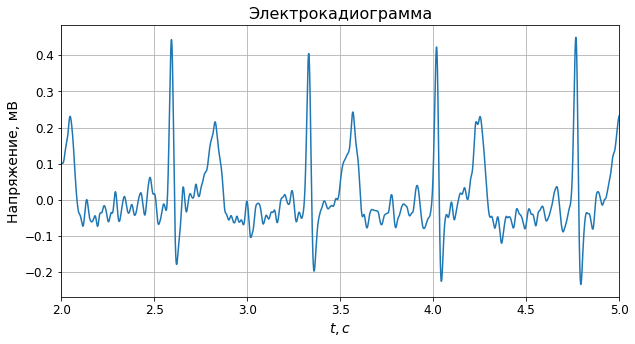

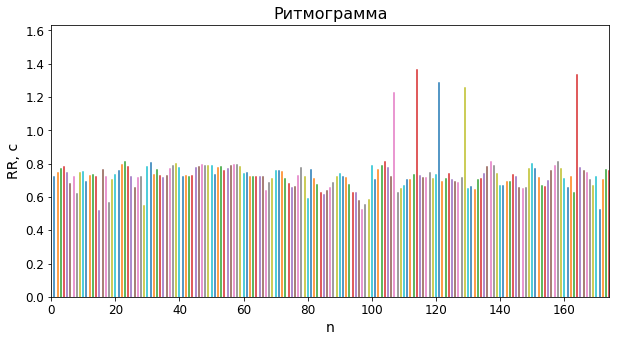

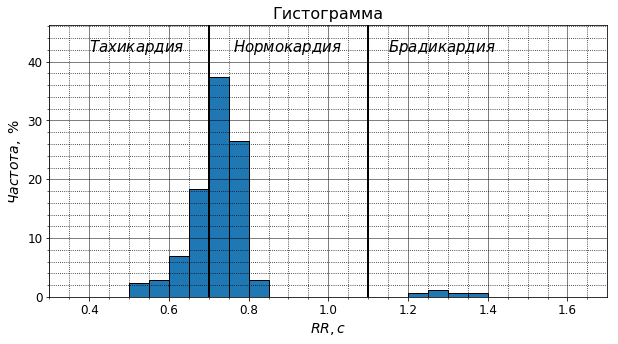

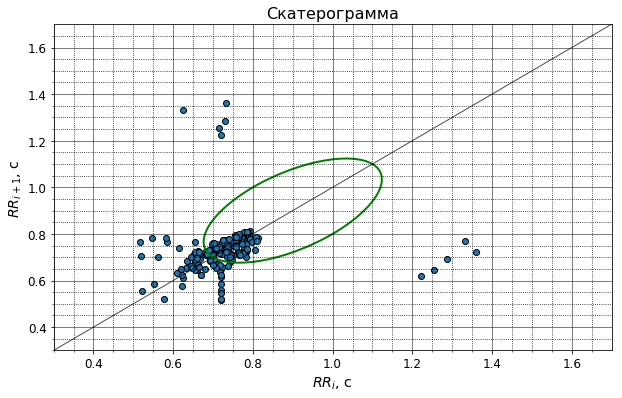

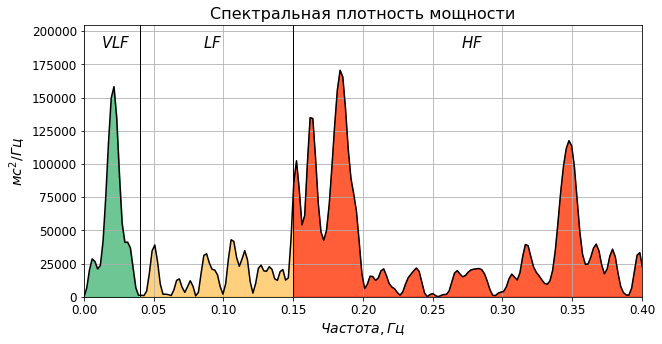

ОЦЕНКА СОСТОЯНИЯ РЕГУЛЯТОРНЫХ СИСТЕМ

Суммарный эффект регуляции:  Умеренная тахикардия - (1)
Функция автоматизма:  Выраженная синусовая аритмия - (1)
Вегетативный гомеостаз:  Вегетативный гомеостаз сохранен - (0)
Устойчивость регуляции:  Дисрегуляция - (-2)
Активность подкорковых нервных центров:  Умеренное ослабление - (-1)


ОЦЕНКА ФУНКЦИОНАЛЬНОГО СОСТОЯНИЯ

Выраженное функциональное напряжение
Ваш показатель активности регуляторных систем: 5


ЗАКЛЮЧЕНИЕ

У вас в настоящее время ухудшенное функциональное состояние. Системы регуляции работают с некоторым напряжением. В ответ на любой стрессовый фактор возникает функциональное напряжение, с которым ВАМ трудно справиться. Для нормализации фукционального состояния Вам рекомендуется снизить психоэмоциональные нагрузки, наладить нормальный режим питания, обратить особое внимание на режим сна и отдыха. Постарайтесь устранить имеющиеся у Вас факторы риска или снизить уровень их воздействия. После этого пройти повторное исследование.


ОСНО

,Наименование,Значение,Норма
1,Частота пульса (HR) уд/мин,82,55-80
2,Среднеквадратическое отклонение (SDNN) мс,113.88,30-100
3,Коэффициент вариации (CV) %,15.57,3-12
4,Среднеквадр. разностная характеристика (RMSSD) мс,155.69,20-50
5,Процент разностных интервалов > 50 мс (PNN50) %,29.31,10-30
6,Мода (Mo) мс,720,700-900
7,Амплитуда моды (AMo) %,37.4,30-50
8,Вариационный размах (MxDMn) мс,844,150-300
9,Стресс-индекс (SI),31,50-150
10,Индекс вегетативного равновесия (IVR),44.31,100-300


In [58]:
start() # Путь к файлу: data/Кругликов.mat  Частота дискретизации: 2000 - Норма
        
        # Путь к файлу: data/Шемякина.mat  Частота дискретизации: 2000 - Выраженное функциональное напряжение